In [169]:
import argparse
import contextlib
import datetime
import io
import logging
import multiprocessing
import os
import random
import sys
from itertools import chain, combinations
from timeit import default_timer as timer

import altair as alt
import altair_viewer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peewee
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from json_tricks import dumps, loads
from playhouse.shortcuts import model_to_dict
from scipy.stats import randint, uniform
from sklearn.datasets import load_iris
from tabulate import tabulate
from IPython.core.display import display, HTML 

from cluster_strategies import (DummyClusterStrategy,
                                MostUncertainClusterStrategy,
                                RandomClusterStrategy,
                                RoundRobinClusterStrategy)
from dataStorage import DataStorage
from experiment_setup_lib import (ExperimentResult,
                                  classification_report_and_confusion_matrix,
                                  get_db, get_single_al_run_stats_row,
                                  get_single_al_run_stats_table_header,
                                  load_and_prepare_X_and_Y)
from sampling_strategies import (BoundaryPairSampler, CommitteeSampler,
                                 RandomSampler, UncertaintySampler)

alt.renderers.enable('altair_viewer')
#  alt.renderers.enable('vegascope')

config = {
    'datasets_path': '../datasets',
    'db': "tunnel",
    'param_list_id': 'best_global_score',
}

db = get_db(db_name_or_type=config['db'])

In [174]:
 # select count(*), dataset_name from experimentresult group by dataset_name;
results = ExperimentResult.select(
    ExperimentResult.dataset_name,
    peewee.fn.COUNT(
        ExperimentResult.id_field).alias('dataset_name_count')).group_by(
            ExperimentResult.dataset_name)

for result in results:
    print("{:>4,d} {}".format(result.dataset_name_count,
                              result.dataset_name))

 551 orange
 545 sylva
 553 hiva
 555 ibn_sina
 536 zebra
 555 dwtc


In [176]:
#  SELECT param_list_id, avg(fit_score), stddev(fit_score), avg(global_score), stddev(global_score), avg(start_set_size) as sss, count(*) FROM experimentresult WHERE start_set_size = 1 GROUP BY param_list_id ORDER BY 7 DESC, 4 DESC LIMIT 30;

results = ExperimentResult.select(
    ExperimentResult.param_list_id,
    peewee.fn.AVG(ExperimentResult.fit_score).alias('avg_fit_score'),
    peewee.fn.STDDEV(ExperimentResult.fit_score).alias('stddev_fit_score'),
    peewee.fn.AVG(ExperimentResult.global_score).alias('avg_global_score'),
    peewee.fn.STDDEV(
        ExperimentResult.global_score).alias('stddev_global_score'),
    peewee.fn.AVG(ExperimentResult.start_set_size).alias('sss'),
    peewee.fn.COUNT(ExperimentResult.id_field).alias('count')).group_by(
        ExperimentResult.param_list_id).order_by(
            peewee.fn.COUNT(ExperimentResult.id_field).desc(),
            peewee.fn.AVG(ExperimentResult.fit_score).desc()).limit(20)

table = []

for result in results:
    data = vars(result)
    data['param_list_id'] = data['__data__']['param_list_id']
    del data['__data__']
    del data['_dirty']
    del data['__rel__']
    table.append(vars(result))

display(HTML(tabulate(table, headers="keys", tablefmt="html")))


avg_fit_score,stddev_fit_score,avg_global_score,stddev_global_score,sss,count,param_list_id
0.930348,0.105443,0.606388,0.313598,1,6,64b73179210ab8e0e51e69764ccde12f
0.928412,0.0999027,0.433891,0.311504,1,6,7d1a62f23838940d1ba579324718f0aa
0.928262,0.116707,0.503081,0.503896,1,6,c2cd010e2b719b4e5ccf5b8f466e1fd5
0.924321,0.113858,0.582781,0.396944,1,6,654478bcfe01e9d9febe75501bd17c61
0.924005,0.104353,0.511911,0.249029,1,6,c67d2c58677a7af14eedbee2c90e675e
0.923221,0.11944,0.518587,0.445439,1,6,69c0a5a7034a6e9e433a85ce3200e661
0.919231,0.129267,0.584561,0.426148,1,6,2c14245f3ef401ad0b4602d19991343d
0.918191,0.129225,0.558451,0.501106,1,6,af121819cf904c847ed7978b44b7d770
0.917097,0.122709,0.593419,0.347246,1,6,9efea32a12854eb6aac801a44c3aa9b1
0.914023,0.101065,0.490415,0.467328,1,6,e7678ee92dcf53cbfc3fb64589798ad1


In [172]:
# SELECT id_field, param_list_id, dataset_path, start_set_size as sss, sampling, cluster, allow_recommendations_after_stop as SA, stopping_criteria_uncertainty as SCU, stopping_criteria_std as SCS, stopping_criteria_acc as SCA, amount_of_user_asked_queries as "#q", acc_test, fit_score, global_score_norm, thread_id, end_time from experimentresult where param_list_id='31858014d685a3f1ba3e4e32690ddfc3' order by end_time, fit_score desc, param_list_id;
best_param_list_id = table[0]['param_list_id']

results = ExperimentResult.select().where(
    ExperimentResult.param_list_id == best_param_list_id)

loaded_data = []
for result in results:
    loaded_data.append(result)
loaded_data

[<ExperimentResult: 2376>,
 <ExperimentResult: 2377>,
 <ExperimentResult: 2378>,
 <ExperimentResult: 2379>,
 <ExperimentResult: 2380>,
 <ExperimentResult: 2381>]

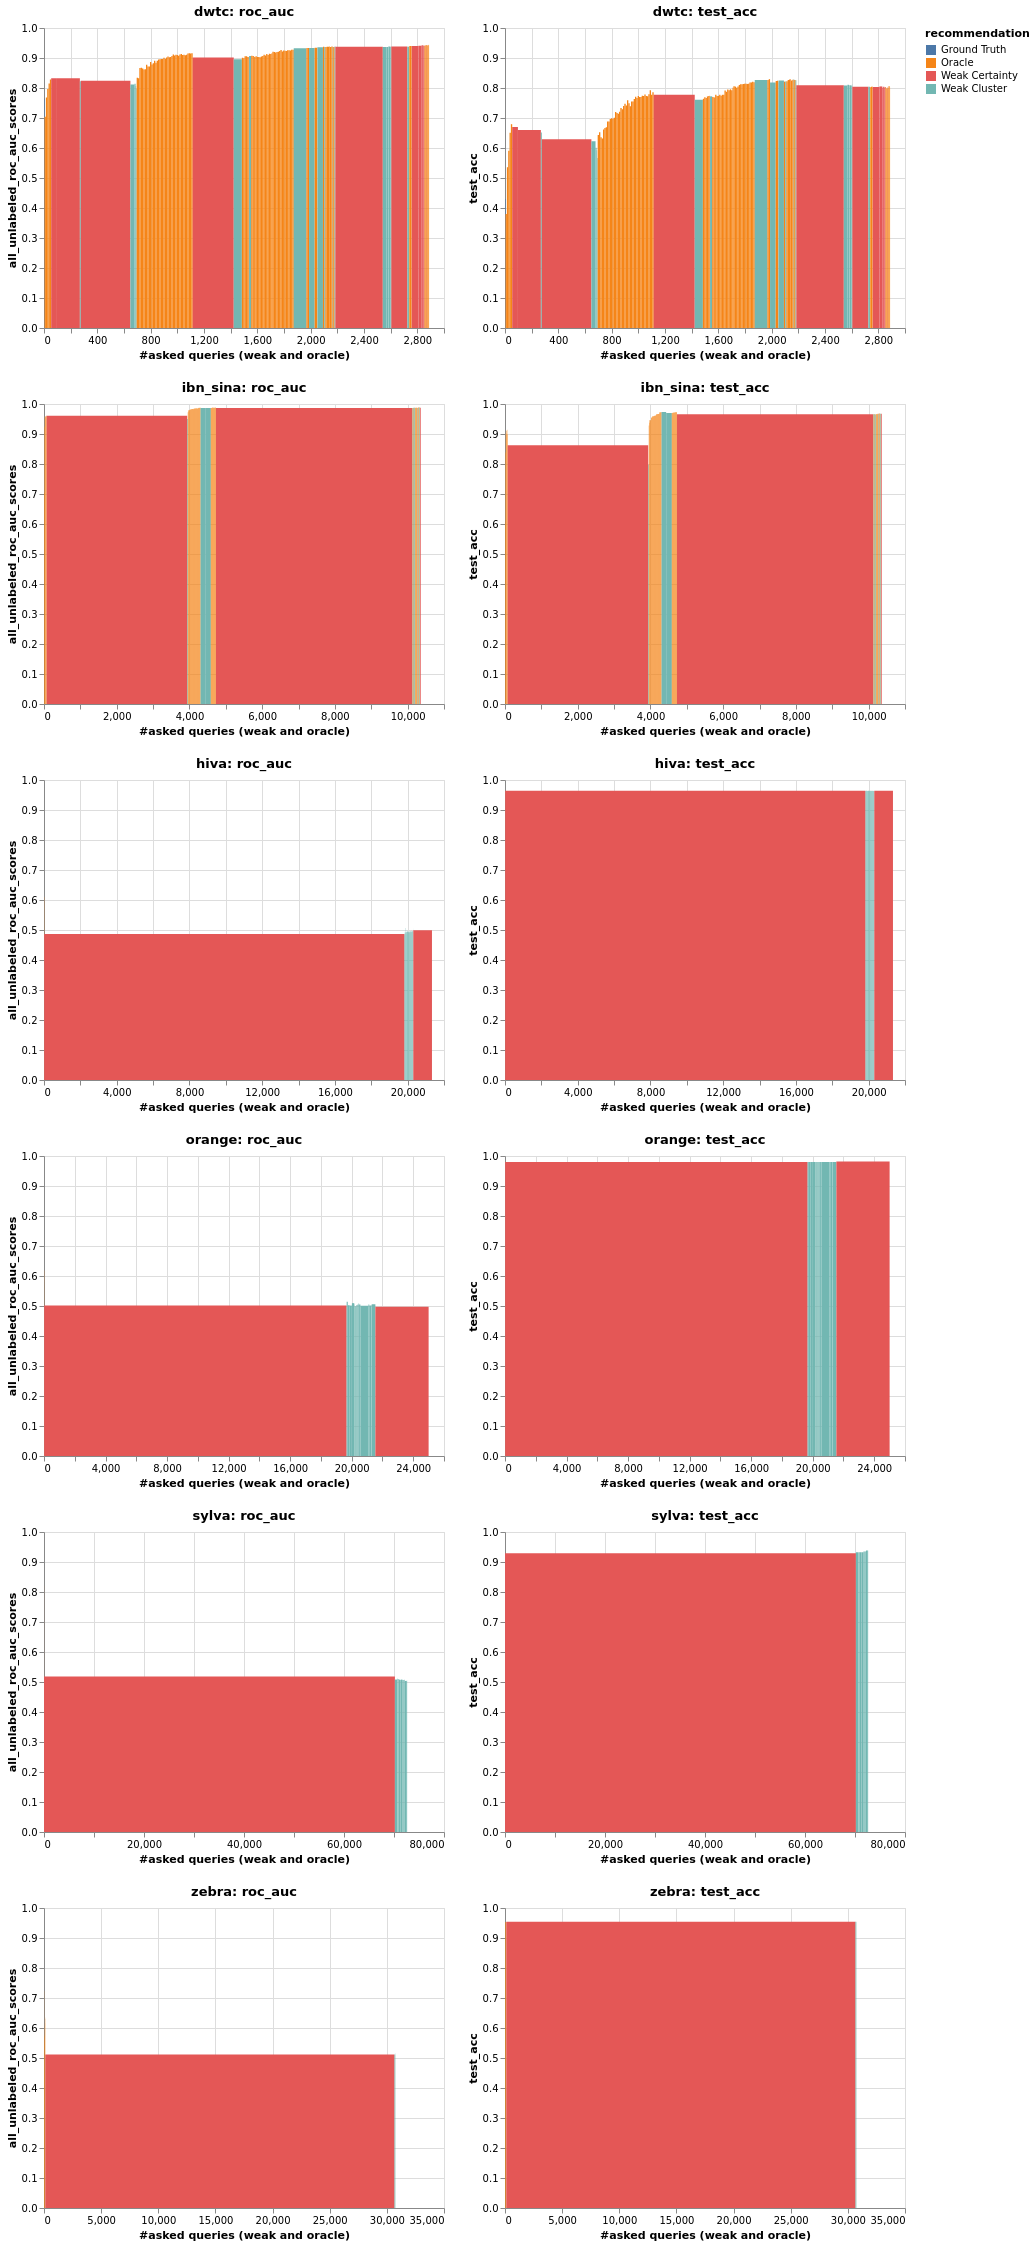

In [173]:
charts = []

alt.renderers.enable('mimetype')

for result in results[:]:
    
    metrics = loads(result.metrics_per_al_cycle)
    test_data_metrics = [metrics['test_data_metrics'][0][f][0]['weighted avg'] for f in range(0, len(metrics['test_data_metrics'][0]))]
    test_acc = [metrics['test_data_metrics'][0][f][0]['accuracy'] for f in range(0, len(metrics['test_data_metrics'][0]))]

    data = pd.DataFrame({
        'iteration': range(0, len(metrics['all_unlabeled_roc_auc_scores'])),
        'all_unlabeled_roc_auc_scores': metrics['all_unlabeled_roc_auc_scores'],
        'query_length': metrics['query_length'],
        'recommendation': metrics['recommendation'],
        'query_strong_accuracy_list': metrics['query_strong_accuracy_list'],
        'f1': [ i['f1-score'] for i in test_data_metrics],
        'test_acc': test_acc,
        #'asked_queries': [sum(metrics['query_length'][:i]) for i in range(0, len(metrics['query_length']))],
    })
    
    data['asked_queries'] = data['query_length'].cumsum()
    data['query_length_cumsum'] = data['asked_queries'].shift(fill_value=0)
    
    #print(data[['asked_queries', 'query_length']])
    
    data['recommendation'] = data['recommendation'].replace({
        'A': 'Oracle', 
        'C': 'Weak Cluster',
        'U': 'Weak Certainty',
        'G': 'Ground Truth',
    })
    
    #data = data[:100]
    
    # calculate global score OHNE 

    chart = alt.Chart(data).mark_rect(
        #point=True, 
        #line=True,
        #interpolate='step-after',
    ).encode(
        x=alt.X('query_length_cumsum', title="#asked queries (weak and oracle)"),
        x2='asked_queries',
        color='recommendation',
        tooltip=[
            'iteration', 'f1', 'test_acc', 'all_unlabeled_roc_auc_scores', 'query_strong_accuracy_list', 'query_length', 'recommendation'
        ],
        #scale=alt.Scale(domain=[0,1])
    ).properties(
        title=result.dataset_name
    ).interactive()
    charts.append(alt.hconcat(
        chart.encode(alt.Y('all_unlabeled_roc_auc_scores', scale=alt.Scale(domain=[0,1]))).properties(title=result.dataset_name + ': roc_auc'),
        #chart.encode(alt.Y('f1', scale=alt.Scale(domain=[0,1]))).properties(title=result.dataset_name + ': f1'),
        chart.encode(alt.Y('test_acc', scale=alt.Scale(domain=[0,1]))).properties(title=result.dataset_name + ': test_acc'),
    ))

alt.vconcat(*charts).configure()